# Detection Models for CGM

### Dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn, torch.optim as optim
from sklearn.metrics import average_precision_score

In [6]:
# Load Dataset: X_train, X_test, y_train, y_test
X_train = np.load('./Output/DietFlag/Xtrain_subjstrat.npy')
X_test = np.load('./Output/DietFlag/Xtest_subjstrat.npy')
y_train = np.load('./Output/DietFlag/ytrain_subjstrat.npy')
y_test = np.load('./Output/DietFlag/ytest_subjstrat.npy')
sub_train = np.load('./Output/DietFlag/subjects_train_strat.npy')
sub_test = np.load('./Output/DietFlag/subjects_test_strat.npy')
h_train = np.load('./Output/DietFlag/h_train_strat.npy')
h_test = np.load('./Output/DietFlag/h_test_strat.npy')
m_train = np.load('./Output/DietFlag/m_train_strat.npy')
m_test = np.load('./Output/DietFlag/m_test_strat.npy')

# Model 1 dim

## Dataloader

In [9]:
param = {'lr': 0.0001, 'dropout': 0.4, 'c_out': 16, 'h': 64, 'batch_size': 16}

In [20]:
# Hyperparameters
BATCH = param['batch_size']
# Prefer MPS if available, otherwise fall back to CPU (Allows usage on Apple Silicon Macs)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on:", device)
#device = "cuda" if torch.cuda.is_available() else "cpu"

Running on: mps


In [ ]:
## Dataset and Dataloader for CGM data:
class CGMDataset(Dataset):
    def __init__(self, X, y):
        # X: (n_samples, L) → we want (n_samples, L, 1)
        self.X = torch.from_numpy(X).float().unsqueeze(-1)
        # y: already (n_samples, L), but make it float32
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# datasets & loaders
train_ds = CGMDataset(X_train, y_train)
val_ds  = CGMDataset(X_test,  y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl  = DataLoader(val_ds, batch_size=BATCH, shuffle=False)


## Bi-LSTM

In [24]:
class CNN_Dilated_BiLSTM_Attn(nn.Module):
    """
    Détection de repas dans des séries CGM (1 min).
    ├─ CNN dilatée : capte les motifs sur 15–60 min
    ├─ Bi-LSTM      : modélise la dynamique temporelle
    ├─ Self-attention: re-pondère les pas de temps pertinents
    └─ Linear       : probabilité de repas à chaque minute
    """
    def __init__(self, inputs_channel = 1, c_out=32, h=16, dr=0.4): #, n_heads=4):
        super().__init__()
        # 1 Convolutions élargies + dilatées
        self.cnn = nn.Sequential(
            nn.Conv1d(inputs_channel, c_out, 15, padding=7, dilation=1), nn.ReLU(),
            nn.Conv1d(c_out, c_out, 3,  padding=2, dilation=2), nn.ReLU(),
            nn.Conv1d(c_out, c_out, 3,  padding=4, dilation=4), nn.ReLU(),
            nn.BatchNorm1d(c_out),
            nn.Dropout(dr)
        )
        # 2 Bi-LSTM
        self.lstm = nn.LSTM(
            c_out, h, num_layers=2,
            batch_first=True, bidirectional=True, dropout=dr
        )
        self.norm = nn.LayerNorm(2*h)
        self.cls  = nn.Linear(2*h, 1)
    def forward(self, x):            # x : (B, L, 1)
        x = self.cnn(x.transpose(1, 2))      # (B, C, L)
        x = x.transpose(1, 2)                # (B, L, C)
        x, _ = self.lstm(x)                  # (B, L, 2h)
        # attn_out, _ = self.attn(x, x, x)     # (B, L, 2h)
        x = self.norm(x) #+ attn_out)          # résiduel + LN
        return self.cls(x).squeeze(-1)       # (B, L)

In [ ]:
import Path
checkpoint = Path("/Users/yentlcollin/CGM/PublicCGM/Notebooks/Final/Final_meal_detection/meal_detection_model_final.pth")
state_dict = torch.load(checkpoint, map_location=device)   # map_location=… permet de charger même sans GPU
model.load_state_dict(state_dict)

In [70]:
# Bi-LSTM Model
model = CNN_Dilated_BiLSTM_Attn(c_out=param['c_out'], h = param['h'], dr = param['dropout']).to(device)

## Weight loss

### Fixed weighting

In [78]:
pos_w = 5
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_w, device=device, dtype=torch.float32)
)

## Training

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np
from sklearn.metrics import average_precision_score
import random
#criterion = nn.BCEWithLogitsLoss()
# scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=4
# )

# Configuration
random.seed(42)
torch.manual_seed(42)


EPOCHS = 9

# Bi-LSTM Model
model = CNN_Dilated_BiLSTM_Attn(c_out=param['c_out'], h = param['h'], dr = param['dropout']).to(device)

optimizer = optim.Adam(model.parameters(), lr=param['lr'], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=param['lr'],
    steps_per_epoch=len(train_dl), epochs=EPOCHS
)

def train_model(model, train_dl, val_dl, optimizer, criterion, epochs=EPOCHS):
    # sanity‐check: make sure neither dataloader is empty
    if len(train_dl.dataset) == 0:
        raise ValueError("Training dataset is empty.")
    if len(val_dl.dataset) == 0:
        raise ValueError("Validation dataset is empty.")

    for epoch in range(1, epochs+1):
        # — TRAINING —
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_dl, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for xb, yb in train_bar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item() * xb.size(0)
            train_bar.set_postfix(batch_loss=loss.item())

        epoch_train_loss = running_loss / len(train_dl.dataset)
        train_bar.close()

        # — VALIDATION —
        model.eval()
        val_loss = 0.0
        val_samples = 0
        all_preds, all_labels = [], []
        val_bar = tqdm(val_dl, desc=f"Epoch {epoch}/{epochs} [Val]  ", leave=False)
        with torch.no_grad():
            for xb, yb in val_bar:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss   = criterion(logits, yb)

                batch_size = xb.size(0)
                val_loss   += loss.item() * batch_size
                val_samples += batch_size

                preds = torch.sigmoid(logits).cpu().numpy().flatten()
                all_preds.extend(preds)
                all_labels.extend(yb.cpu().numpy().flatten())

                # only divide once we've seen at least one sample
                avg_loss = val_loss / val_samples if val_samples > 0 else 0.0
                val_bar.set_postfix(val_loss=f"{avg_loss:.4f}")

        # final per‐epoch losses (also safe‐guarded)
        epoch_val_loss = val_loss / len(val_dl.dataset) if len(val_dl.dataset) > 0 else 0.0
        val_bar.close()

        # compute AUC-PR if we have any labels
        if len(all_labels) > 0:
            binary_labels = (np.array(all_labels) >= 0.5).astype(int)
            auc_preds     = np.array(all_preds)
            auc_preds[auc_preds < 0.1] = 0.0  # seuil uniquement pour l'AUC

            ap = average_precision_score(binary_labels, auc_preds)
            ap_text = f"| AUC-PR {ap:.4f}"
        else:
            ap_text = "| AUC-PR N/A (no validation samples)"

        print(
            f"Epoch {epoch}/{epochs} ➜ "
            f"Train BCE {epoch_train_loss:.4f} | "
            f"Val   BCE {epoch_val_loss:.4f} {ap_text}"
        )

    return model

model = train_model(model, train_dl, val_dl, optimizer, criterion, epochs=EPOCHS)

{'lr': 0.0001, 'dropout': 0.4, 'c_out': 16, 'h': 64, 'batch_size': 16}


Epoch 1/9 ➜ Train BCE 0.6290 | Val   BCE 0.5599 | AUC-PR 0.3437


Epoch 2/9 ➜ Train BCE 0.5537 | Val   BCE 0.5339 | AUC-PR 0.4179


Epoch 3/9 ➜ Train BCE 0.5330 | Val   BCE 0.5205 | AUC-PR 0.4341


Epoch 4/9 ➜ Train BCE 0.5236 | Val   BCE 0.5273 | AUC-PR 0.4323


Epoch 5/9 ➜ Train BCE 0.5156 | Val   BCE 0.5128 | AUC-PR 0.4507


Epoch 6/9 ➜ Train BCE 0.5107 | Val   BCE 0.5089 | AUC-PR 0.4509


Epoch 7/9 ➜ Train BCE 0.5067 | Val   BCE 0.5070 | AUC-PR 0.4537


Epoch 8/9 ➜ Train BCE 0.5044 | Val   BCE 0.5082 | AUC-PR 0.4530


Epoch 9/9 ➜ Train BCE 0.5036 | Val   BCE 0.5067 | AUC-PR 0.4540


In [ ]:
from pathlib import Path
import torch
import random

model_weights_path = Path('./Notebooks/Final/Final_meal_detection/meal_detection_model_final_figures.pth')
model_weights_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path.resolve()}")

Model weights saved to /Users/yentlcollin/CGM/PublicCGM/Notebooks/Final/Final_meal_detection/meal_detection_model_final_figures.pth


In [212]:
# pick one random example by index
idx = random.randrange(len(val_ds))
xb, yb = val_ds[idx]            # xb: (SEQ_LEN, 1), yb: (SEQ_LEN,)
x_seq = xb.squeeze(-1)               # -> (SEQ_LEN,)
label = yb       

## Plot result

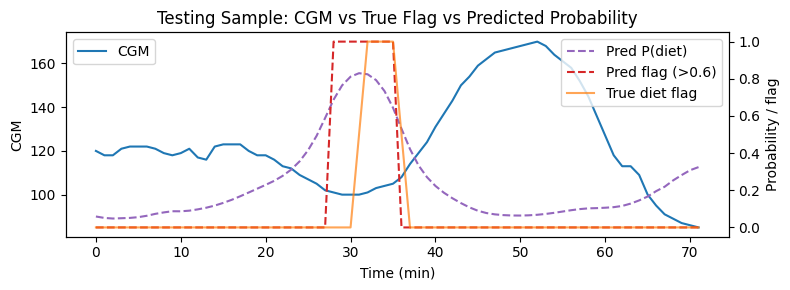

In [215]:

import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# TESTSET

SEQ_LEN = 72
DT      = 5  # minutes per step

# pick one random example by index
idx = random.randrange(len(val_ds))


xb, yb = val_ds[idx]            # xb: (SEQ_LEN, 1), yb: (SEQ_LEN,)
x_seq = xb.squeeze(-1)               # -> (SEQ_LEN,)
label = yb                           # -> (SEQ_LEN,)

# add batch dim and send to device
xb = xb.unsqueeze(0).to(device)      # -> (1, SEQ_LEN, 1)

# forward pass
with torch.no_grad():
    prob = torch.sigmoid(model(xb))      # -> (1, SEQ_LEN)
    p_seq = prob.squeeze(0)       
# ----------------------- NEW: seuil 0.5 ----------------------
flag_pred = (p_seq > 0.6).float()        # 1 si proba > 0.5, sinon 0

# ---- after your torch.no_grad() block ----
p_seq_np      = p_seq.detach().cpu().numpy()
flag_pred_np  = flag_pred.detach().cpu().numpy()
x_seq_np      = x_seq.detach().cpu().numpy()          # optional, for clarity
label_np      = label.detach().cpu().numpy()          # optional

# time axis
t = np.arange(SEQ_LEN)

# plotting
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

ax1.plot(t, x_seq_np,        label="CGM")
ax2.plot(t, p_seq_np,  "C4--", label="Pred P(diet)")      # <-- fixed
ax2.plot(t, flag_pred_np, "C3--", label="Pred flag (>0.6)")
ax2.plot(t, label_np,   "C1-", alpha=0.7, label="True diet flag")

ax1.set_xlabel("Time (min)")
ax1.set_ylabel("CGM")
ax2.set_ylabel("Probability / flag")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Testing Sample: CGM vs True Flag vs Predicted Probability")
plt.tight_layout()
plt.show()

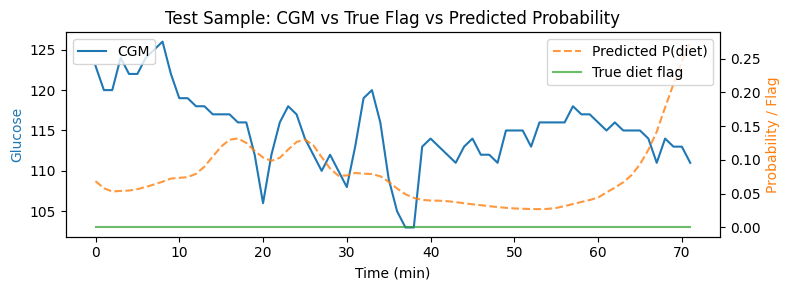

In [216]:
# TRAINSET
import matplotlib.pyplot as plt
import numpy as np
import torch

SEQ_LEN = 72
DT      = 1  # minutes per step

# 1) grab one batch from train_dl
xb_batch, yb_batch = next(iter(train_dl))   # xb: (B,360,1), yb: (B,360)

# 2) pick the first sample
x_seq, label_seq = xb_batch[0], yb_batch[0]  # x_seq: (360,1), label_seq: (360,)

# 3) run it through the model
model.eval()
with torch.no_grad():
    # need shape (1,360,1) → model returns (1,360) logits
    logits = model(x_seq.unsqueeze(0).to(device))
    probs  = torch.sigmoid(logits)[0].cpu().numpy()  # (360,)

# 4) pull out the raw CGM values
cgm = x_seq.squeeze(-1).numpy()  # (360,)

# 5) make a time axis
t = np.arange(SEQ_LEN) * DT

# 6) plot on dual y-axes
fig, ax1 = plt.subplots(figsize=(8,3))
ax2 = ax1.twinx()

ax1.plot(t, cgm,       color='tab:blue', label="CGM")
ax2.plot(t, probs,    '--', color='tab:orange', label="Predicted P(diet)", alpha=0.8)
ax2.plot(t, label_seq,    '-', color='tab:green',  label="True diet flag", alpha=0.7)

ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Glucose", color='tab:blue')
ax2.set_ylabel("Probability / Flag", color='tab:orange')

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Test Sample: CGM vs True Flag vs Predicted Probability")
plt.tight_layout()
plt.show()


## Full Test

### Plot and compute full test

In [30]:
import torch
import numpy as np

THRESH = 0.40          # ton seuil 0.6
device  = next(model.parameters()).device   # récupère le même device que le modèle

def collect_sequences(model, val_ds, thresh=0.60):
    device  = next(model.parameters()).device
    model.eval()

    x_list, pred_list, label_list, prob_list = [], [], [], []

    with torch.no_grad():
        for xb, yb in val_ds:                 # xb : (SEQ_LEN,1)  yb : (SEQ_LEN,)
            x_seq = xb.squeeze(-1)            # (SEQ_LEN,)

            prob = torch.sigmoid(model(xb.unsqueeze(0).to(device)))  # (1,SEQ_LEN)
            p_seq = prob.squeeze(0)           # (SEQ_LEN,)
            flag_pred = (p_seq > thresh).float()

            x_list.append(x_seq.cpu().numpy())
            pred_list.append(flag_pred.cpu().numpy())
            label_list.append( yb.cpu().numpy())
            prob_list.append(p_seq.cpu().numpy())

    return x_list, pred_list, label_list, prob_list   # trois listes parallèles

In [32]:
import numpy as np
from collections import defaultdict, OrderedDict

SEQ_LEN = 72     # longueur des fenêtres

# ---------- 1. Reconstruction "simple" (premier+dernier) ----------
def _reconstruct_from_windows(windows):
    """Concatène correctement des fenêtres stride=1 (principe premier+dernier)."""
    if len(windows) == 1:
        return windows[0].copy()
    head = [w[0] for w in windows[:-1]]
    tail = windows[-1]
    return np.concatenate([head, tail])

# ---------- 2. Reconstruction par max pour les prédictions ----------
def _reconstruct_pred_max(windows):
    """Reconstruit une série en prenant le max sur les recouvrements."""
    n = len(windows)               # nb de fenêtres
    total_len = n + SEQ_LEN - 1    # longueur finale
    agg = np.zeros(total_len, dtype=windows[0].dtype)

    for k, w in enumerate(windows):
        agg[k : k + SEQ_LEN] = np.maximum(agg[k : k + SEQ_LEN], w)

    return agg

import numpy as np

def _reconstruct_prob_average(prob_windows):
    """
    Recolle les fenêtres de probabilité par moyenne sur recouvrements.
    """
    n_w, w_len = len(prob_windows), len(prob_windows[0])
    total_len = w_len + (n_w - 1)  # Assuming stride=1
    summed = np.zeros(total_len)
    counts = np.zeros(total_len)

    for i, window in enumerate(prob_windows):
        start = i
        end = i + w_len
        summed[start:end] += window
        counts[start:end] += 1

    return (summed / counts).astype(float)


# ---------- 2. Reconstruction par ratio pour les prédictions ----------
def _reconstruct_pred_ratio(windows, *, ratio=0.5, seq_len=None):
    """
    Reconstruit une série binaire à partir de fenêtres qui se recouvrent.
    
    Pour chaque position, on calcule la proportion de 1 dans toutes les
    fenêtres qui couvrent cette position, puis on compare à `ratio`.
    
    Parameters
    ----------
    windows : list[np.ndarray]
        Liste de fenêtres (shape = (SEQ_LEN,)) contenant 0 ou 1.
    ratio : float, optional
        Seuil entre 0 et 1. La sortie sera 1 si la proportion de 1
        dépasse ce seuil (>= ratio). Par défaut 0.5 (= majorité stricte).
    seq_len : int, optional
        Longueur d'une fenêtre. Si None, on l'infère depuis windows[0].
    
    Returns
    -------
    agg : np.ndarray
        Tableau binaire de longueur n + SEQ_LEN - 1.
    """
    if seq_len is None:
        seq_len = len(windows[0])
    n = len(windows)
    total_len = n + seq_len - 1

    # même dtype que les fenêtres → pas de conflit
    sum_ones   = np.zeros(total_len, dtype=windows[0].dtype)
    vote_count = np.zeros(total_len, dtype=np.int32)

    for k, w in enumerate(windows):
        sum_ones[k : k + seq_len]   += w          # OK, mêmes dtypes
        vote_count[k : k + seq_len] += 1

    proportion = sum_ones / vote_count
    agg = (proportion >= ratio).astype(windows[0].dtype)
    return agg


In [33]:
from collections import defaultdict, OrderedDict

def regroup_timeseries_multi(x_list, pred_list, label_list, sub_test, ratio=0.8, prob_list=None, threshold=0.5):
    """
    Construit un dict {id: {'x', 'pred', 'label', 'prob', 'prob_flag'}} :
      - x         : recollé (principe premier+dernier)
      - pred      : max sur recouvrements
      - label     : recollé (premier+dernier)
      - prob      : moyenne sur recouvrements
      - prob_flag : 1 si prob > threshold, sinon 0
    """
    assert len(x_list) == len(pred_list) == len(label_list) == len(sub_test)
    if prob_list is not None:
        assert len(prob_list) == len(sub_test)

    groups_x = defaultdict(list)
    groups_pred = defaultdict(list)
    groups_label = defaultdict(list)
    groups_prob = defaultdict(list) if prob_list is not None else None
    id_order = []

    # 1) regrouper les fenêtres par id
    for i, (xw, pw, lw, idx) in enumerate(zip(x_list, pred_list, label_list, sub_test)):
        if idx not in groups_x:
            id_order.append(idx)
        groups_x[idx].append(xw)
        groups_pred[idx].append(pw)
        groups_label[idx].append(lw)
        if prob_list is not None:
            groups_prob[idx].append(prob_list[i])

    # 2) reconstruction
    ts_dict = OrderedDict()
    for idx in id_order:
        x_ts     = _reconstruct_from_windows(groups_x[idx])
        pred_ts  = _reconstruct_pred_ratio(groups_pred[idx], ratio=ratio)
        label_ts = _reconstruct_from_windows(groups_label[idx])

        ts_dict[idx] = {'x': x_ts, 'pred': pred_ts, 'label': label_ts}

        if prob_list is not None:
            prob_ts = _reconstruct_prob_average(groups_prob[idx])  
            prob_flag_ts = (prob_ts > threshold).astype(float)  # Ajout du flag basé sur le seuil
            ts_dict[idx]['prob'] = prob_ts
            ts_dict[idx]['prob_flag'] = prob_flag_ts

    return ts_dict


In [34]:
import matplotlib.pyplot as plt

def plot_timeseries(ts_dict, idx, figsize=(12,4)):
    """
    Affiche CGM + prédiction + label pour l’identifiant donné.
    ts_dict : résultat de regroup_timeseries_multi
    idx     : id à tracer
    """
    ts = ts_dict[idx]
    x, pred, label = ts['x'], ts['pred'], ts['label']
    t = np.arange(len(x))              # abscisse en pas de 5 min

    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    ax1.plot(t, x, label='CGM')
    ax2.step(t, label, where='post', label='True flag', linestyle='--', color='orange', linewidth=1.5)
    ax2.step(t, pred,  where='post', label='Pred flag',  linestyle='--', color='red')

    ax1.set_xlabel('Time step (5 min)')
    ax1.set_ylabel('CGM')
    ax2.set_ylabel('Flag (0/1)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'Série reconstituée – id {idx}')
    plt.tight_layout()
    plt.show()


In [35]:
import numpy as np
import plotly.graph_objects as go

def plot_timeseries_plotly(
    ts_dict,
    idx,
    width=900,
    height=400,
    prob_list=False,
    plot_prob=False,
):
    """
    Affiche CGM + prédiction + label pour l’identifiant donné
    (et éventuellement la probabilité associée), en Plotly.

    Paramètres
    ----------
    ts_dict : dict
        Résultat de regroup_timeseries_multi ;
        chaque entrée doit contenir au moins les clés
        'x', 'label', 'pred' et, si plot_prob=True, 'prob'.
    idx : hashable
        Identifiant de la série à tracer.
    width, height : int
        Dimensions de la figure.
    prob_list : bool
        Si True, on lit les prédictions binaires dans 'prob_flag'
        (utile quand tu as deux listes différentes :
        probabilité et prédiction seuillée).
    plot_prob : bool
        Si True, trace aussi la courbe de probabilité (0–1).
    """
    ts = ts_dict[idx]

    # Choix de la série « prédiction binaire »
    pred = ts["prob_flag"] if prob_list else ts["pred"]

    x, label = ts["x"], ts["label"]
    t = np.arange(len(x))          # abscisse en pas de 5 min

    fig = go.Figure()

    # CGM (axe Y principal)
    fig.add_trace(
        go.Scatter(
            x=t, y=x,
            mode="lines",
            name="CGM",
            yaxis="y1"
        )
    )

    # True flag (axe Y2, style « step post »)
    fig.add_trace(
        go.Scatter(
            x=t, y=label,
            mode="lines",
            line=dict(dash="dash", width=2, color="orange"),
            name="True flag",
            yaxis="y2",
            line_shape="hv"   # courbe en escalier (post-step)
        )
    )

    # Pred flag (axe Y2)
    fig.add_trace(
        go.Scatter(
            x=t, y=pred,
            mode="lines",
            line=dict(dash="dash", width=2, color="red"),
            name="Pred flag",
            yaxis="y2",
            line_shape="hv"
        )
    )

    # Probabilité, si demandée
    if plot_prob:
        if "prob" not in ts:
            raise KeyError(
                "plot_prob=True mais la clé 'prob' est absente de ts_dict[idx]"
            )
        fig.add_trace(
            go.Scatter(
                x=t, y=ts["prob"],
                mode="lines",
                line=dict(width=2, color="blue"),
                name="Probabilité",
                yaxis="y2"   # même axe 0–1
            )
        )

    # Mise en page générale
    fig.update_layout(
        title=f"Série reconstituée – id {idx}",
        width=width,
        height=height,
        xaxis=dict(title="Time step (5 min)"),
        yaxis=dict(title="CGM"),
        yaxis2=dict(
            title="Flag / Proba (0–1)",
            overlaying="y",
            side="right",
            range=[-0.05, 1.05]
        ),
        legend=dict(
            orientation="h", yanchor="bottom", y=1.02,
            xanchor="right", x=1
        ),
        margin=dict(l=50, r=60, t=60, b=40)
    )

    fig.show()
    return fig


In [103]:
# 1) récupérer les fenêtres
x_list, pred_list, label_list, prob_list = collect_sequences(model, val_ds, thresh = 0.36)

In [383]:
sub_test.shape

(25050,)

In [104]:
# 2) reconstruire par id
ts_dict = regroup_timeseries_multi(x_list, pred_list, label_list, sub_test, ratio = 0.77, prob_list=None)
fig = plot_timeseries_plotly(ts_dict, idx=4, prob_list=False, plot_prob = False)


In [ ]:

# 2) reconstruire par id
ts_dict = regroup_timeseries_multi(x_list, pred_list, label_list, sub_test, ratio = 0.5, prob_list=prob_list, threshold=0.42)
# 3) afficher, par exemple pour l’id 4
fig = plot_timeseries_plotly(ts_dict, idx=4, prob_list=True, plot_prob = False)

In [70]:
# 1) Write to HTML
output_dir = "/Users/yentlcollin/CGM/PublicCGM/Notebooks/Final/save_result"
fname = os.path.join(output_dir, f"series_{idx}.html")
fig.write_html(fname, include_plotlyjs="cdn")

### Metrics and evaluation full test

In [39]:
import numpy as np
from collections import Counter   # ← conservé, même s’il n’est pas utilisé ici

# ────────────────────────────────────────────────────────────────
def _events_from_series(series):
    """Retourne la liste [(start, end)] (indices inclus) des segments où series == 1."""
    events = []
    in_evt = False; start = None
    for i, v in enumerate(series):
        if v and not in_evt:
            in_evt, start = True, i
        elif not v and in_evt:
            events.append((start, i - 1)); in_evt = False
    if in_evt:
        events.append((start, len(series) - 1))
    return events


def _overlap(a, b, tol: int = 0):
    """
    True si les intervalles [a0,a1] et [b0,b1] ont au moins 1 point commun,
    sachant qu’on élargit chaque borne de ± tol.
    """
    return not (a[1] + tol < b[0] - tol or b[1] + tol < a[0] - tol)
# ────────────────────────────────────────────────────────────────


def compute_event_metrics(ts_dict, prob_list: bool = False, imprecision: int = 0):
    """
    ts_dict[id] = {'pred': array binaires, 'label': array binaires}
    
    Paramètres
    ----------
    prob_list : bool
        Si True, on utilise d['prob_flag'] au lieu de d['pred'].
    imprecision : int, optionnel (défaut = 0)
        Tolérance (en nombre d’indices) pour considérer qu’un évènement prédit
        « touche » un évènement réel.
    
    Renvoie
    -------
    dict contenant rappel, précision, couverture moyenne et taux de faux évts.
    """
    TP_evt = FN_evt = TP_pred = FP_pred = cover_sum = nb_true_evt = 0

    for d in ts_dict.values():
        label = d['label'].astype(bool)
        pred  = d['prob_flag'].astype(bool) if prob_list else d['pred'].astype(bool)

        true_evts = _events_from_series(label)
        pred_evts = _events_from_series(pred)

        # --- rappel & couverture ---------------------------------
        for e in true_evts:
            nb_true_evt += 1
            overlaps = [p for p in pred_evts if _overlap(e, p, imprecision)]
            if overlaps:
                TP_evt += 1
                # Couverture : proportion de l’évènement réel effectivement couvert
                covered = sum(pred[max(e[0], p[0]):min(e[1], p[1]) + 1].sum()
                              for p in overlaps)
                cover_sum += covered / (e[1] - e[0] + 1)
            else:
                FN_evt += 1

        # --- précision -------------------------------------------
        for p in pred_evts:
            if any(_overlap(p, e, imprecision) for e in true_evts):
                TP_pred += 1
            else:
                FP_pred += 1

    recall    = TP_evt / nb_true_evt if nb_true_evt else np.nan
    precision = TP_pred / (TP_pred + FP_pred) if (TP_pred + FP_pred) else np.nan
    coverage  = cover_sum / nb_true_evt if nb_true_evt else np.nan

    return {
        'recall_evt'     : recall,
        'precision_evt'  : precision,
        'coverage_mean'  : coverage,
        'false_evt_rate' : 1 - precision
    }


In [ ]:
# 2) calcul des métriques

metrics = compute_event_metrics(ts_dict, prob_list = True, imprecision = 3)
for k,v in metrics.items():
    print(f"{k:<15}: {100*v:.2f} %")

In [105]:
ts_dict = regroup_timeseries_multi(x_list, pred_list, label_list, sub_test, ratio = 0.77, prob_list=None)

In [ ]:
# 2) calcul des métriques

metrics = compute_event_metrics(ts_dict, prob_list = False, imprecision = 0)
for k,v in metrics.items():
    print(f"{k:<15}: {100*v:.2f} %")

recall_evt     : 80.13 %
precision_evt  : 72.08 %
coverage_mean  : 59.54 %
false_evt_rate : 27.92 %


# Evaluation

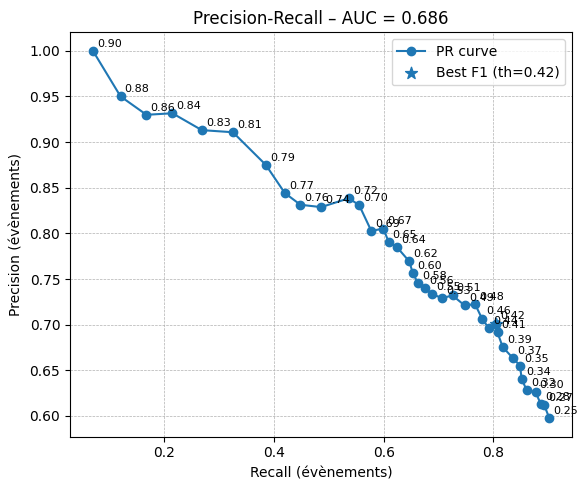

   threshold  recall_evt  precision_evt  coverage_mean     F1
0      0.250       0.902          0.597          0.728  0.719
1      0.268       0.893          0.612          0.709  0.726
2      0.285       0.886          0.613          0.692  0.725
3      0.302       0.877          0.626          0.678  0.731
4      0.320       0.861          0.628          0.664  0.726
5      0.338       0.852          0.640          0.649  0.731
6      0.355       0.849          0.655          0.639  0.739
7      0.372       0.836          0.663          0.629  0.740
8      0.390       0.817          0.675          0.612  0.740
9      0.408       0.808          0.691          0.598  0.745


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc   # pip install scikit-learn si besoin

# ------------------------------------------------------------
# 1.  Paramètres
# ------------------------------------------------------------
thresholds = np.linspace(0.25, 0.95, 41)        # 41 points de 0.00 à 1.00
ratio      = 0.5                              # idem à votre appel actuel
ts_kwargs   = dict(                           # kwargs communs
    x_list = x_list,
    pred_list = pred_list,
    label_list = label_list,
    sub_test = sub_test,
    prob_list = prob_list
)

# ------------------------------------------------------------
# 2.  Boucle sur les seuils
# ------------------------------------------------------------
precisions, recalls, coverages = [], [], []

for th in thresholds:
    ts_dict = regroup_timeseries_multi(**ts_kwargs, ratio=ratio, threshold=th)
    m       = compute_event_metrics(ts_dict, prob_list= True, imprecision=3)

    precisions.append(m['precision_evt'])
    recalls.append(m['recall_evt'])
    coverages.append(m['coverage_mean'])

precisions = np.array(precisions, dtype=float)
recalls    = np.array(recalls,    dtype=float)
coverages  = np.array(coverages,  dtype=float)

# Supprime les points où l’une des métriques est NaN (possible s’il n’y a aucun évènement)
valid      = ~np.isnan(precisions) & ~np.isnan(recalls)
precisions = precisions[valid]
recalls    = recalls[valid]
coverages  = coverages[valid]
thresh_ok  = thresholds[valid]

# ------------------------------------------------------------
# 3.  AUC & seuil optimal (F-score)
# ------------------------------------------------------------
# Le calcul AUC suppose recall trié croissant
order      = np.argsort(recalls)
auc_pr     = auc(recalls[order], precisions[order])

f1_scores  = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx   = np.nanargmax(f1_scores)
best_th    = thresh_ok[best_idx]

# ------------------------------------------------------------
# 4.  Affichages
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, marker='o', linestyle='-', label='PR curve')
plt.scatter(recalls[best_idx], precisions[best_idx], s=80, marker='*',
            label=f'Best F1 (th={best_th:.2f})')

for r, p, t in zip(recalls, precisions, thresh_ok):
    plt.annotate(f'{t:.2f}', xy=(r, p), xytext=(3, 3),
                 textcoords='offset points', fontsize=8)

plt.xlabel('Recall (évènements)')
plt.ylabel('Precision (évènements)')
plt.title(f'Precision-Recall – AUC = {auc_pr:.3f}')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5.  (optionnel) Tableau récapitulatif
# ------------------------------------------------------------
import pandas as pd
summary = pd.DataFrame({
    'threshold' : thresh_ok,
    'recall_evt': recalls,
    'precision_evt': precisions,
    'coverage_mean': coverages,
    'F1': f1_scores
}).round(3).sort_values('threshold').reset_index(drop=True)

print(summary.head(10))          # ou summary.to_csv('pr_curve.csv', index=False)


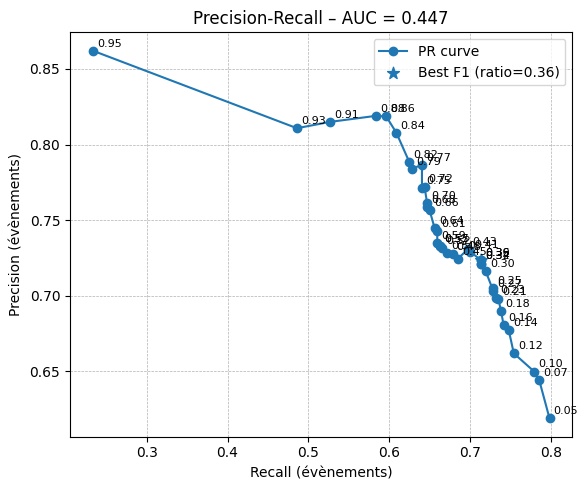

   threshold  recall_evt  precision_evt  coverage_mean     F1
0      0.050       0.798          0.619          0.576  0.697
1      0.073       0.785          0.644          0.560  0.708
2      0.095       0.779          0.650          0.554  0.709
3      0.118       0.754          0.662          0.544  0.705
4      0.140       0.748          0.677          0.537  0.711
5      0.162       0.741          0.681          0.533  0.710
6      0.185       0.738          0.690          0.528  0.713
7      0.208       0.735          0.698          0.525  0.716
8      0.230       0.732          0.699          0.520  0.715
9      0.252       0.729          0.705          0.510  0.717


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc   # pip install scikit-learn si besoin

# ------------------------------------------------------------
# 1.  Paramètres
# ------------------------------------------------------------
threshold = 0.6        # 41 points de 0.00 à 1.00
ratio      = np.linspace(0.05, 0.95, 41)                              # idem à votre appel actuel
ts_kwargs   = dict(                           # kwargs communs
    x_list = x_list,
    pred_list = pred_list,
    label_list = label_list,
    sub_test = sub_test,
    prob_list = prob_list
)

# ------------------------------------------------------------
# 2.  Boucle sur les seuils
# ------------------------------------------------------------
precisions, recalls, coverages = [], [], []

for r in ratio:
    ts_dict = regroup_timeseries_multi(**ts_kwargs, ratio=r, threshold=threshold)
    m       = compute_event_metrics(ts_dict, prob_list= False, imprecision=3)

    precisions.append(m['precision_evt'])
    recalls.append(m['recall_evt'])
    coverages.append(m['coverage_mean'])

precisions = np.array(precisions, dtype=float)
recalls    = np.array(recalls,    dtype=float)
coverages  = np.array(coverages,  dtype=float)

# Supprime les points où l’une des métriques est NaN (possible s’il n’y a aucun évènement)
valid      = ~np.isnan(precisions) & ~np.isnan(recalls)
precisions = precisions[valid]
recalls    = recalls[valid]
coverages  = coverages[valid]
ratio_ok  = ratio[valid]

# ------------------------------------------------------------
# 3.  AUC & seuil optimal (F-score)
# ------------------------------------------------------------
# Le calcul AUC suppose recall trié croissant
order      = np.argsort(recalls)
auc_pr     = auc(recalls[order], precisions[order])

f1_scores  = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx   = np.nanargmax(f1_scores)
best_th    = ratio[best_idx]

# ------------------------------------------------------------
# 4.  Affichages
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, marker='o', linestyle='-', label='PR curve')
plt.scatter(recalls[best_idx], precisions[best_idx], s=80, marker='*',
            label=f'Best F1 (ratio={best_th:.2f})')

for r, p, t in zip(recalls, precisions, ratio_ok):
    plt.annotate(f'{t:.2f}', xy=(r, p), xytext=(3, 3),
                 textcoords='offset points', fontsize=8)

plt.xlabel('Recall (évènements)')
plt.ylabel('Precision (évènements)')
plt.title(f'Precision-Recall – AUC = {auc_pr:.3f}')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 5.  Tableau récapitulatif
# ------------------------------------------------------------
import pandas as pd
summary = pd.DataFrame({
    'threshold' : ratio_ok,
    'recall_evt': recalls,
    'precision_evt': precisions,
    'coverage_mean': coverages,
    'F1': f1_scores
}).round(3).sort_values('threshold').reset_index(drop=True)

print(summary.head(10))          # ou summary.to_csv('pr_curve.csv', index=False)


In [370]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc

# ───────────────────────────────────────────────────────────────
# 1.  Hyper-paramètres à balayer
# ───────────────────────────────────────────────────────────────
threshold_list = np.linspace(0.4, 0.90, 10)   # ← 17 valeurs de 0.10 à 0.90
ratio_list     = np.linspace(0.05, 0.95, 41)   # ← 41 valeurs de 0.05 à 0.95

# ───────────────────────────────────────────────────────────────
# 2.  Boucle double threshold × ratio
# ───────────────────────────────────────────────────────────────
results = []

for th in threshold_list:
    # 2-a. Séquences binaires pour CE seuil de probabilité
    x_list, pred_list, label_list, prob_list = collect_sequences(
        model, val_ds, thresh=th
    )

    for r in ratio_list:
        # 2-b. Regroupement par identifiant
        ts_dict = regroup_timeseries_multi(
            x_list, pred_list, label_list,
            sub_test=sub_test,
            ratio=r,
            prob_list=prob_list,
            threshold=0.5       # ← même seuil que collect_sequences !
        )

        # 2-c. Métriques évènementielles
        m = compute_event_metrics(ts_dict, prob_list=False, imprecision=3)

        prec, rec, cov = m['precision_evt'], m['recall_evt'], m['coverage_mean']

        # Ignore les cas sans évènements (NaN)
        if np.isnan(prec) or np.isnan(rec):
            continue

        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        results.append({
            'threshold'     : th,
            'ratio'         : r,
            'precision_evt' : prec,
            'recall_evt'    : rec,
            'coverage_mean' : cov,
            'F1'            : f1,
        })

# ───────────────────────────────────────────────────────────────
# 3.  Résultat optimal
# ───────────────────────────────────────────────────────────────
res_df   = pd.DataFrame(results).round(4)
best_row = res_df.loc[res_df['F1'].idxmax()]

best_th   = best_row['threshold']
best_ratio = best_row['ratio']

print("↪️  Meilleur couple : threshold = {:.2f}, ratio = {:.2f} (F1 = {:.3f})"
      .format(best_th, best_ratio, best_row['F1']))

# (optionnel) Aperçu des 10 meilleurs couples
print(res_df.sort_values('F1', ascending=False).head(10))

# ───────────────────────────────────────────────────────────────
# 4.  Reconstruction finale avec les meilleurs hyper-paramètres
# ───────────────────────────────────────────────────────────────
# On régénère les séquences pour le threshold gagnant
x_best, pred_best, label_best, prob_best = collect_sequences(
    model, val_ds, thresh=best_th
)

ts_dict_best = regroup_timeseries_multi(
    x_best, pred_best, label_best,
    sub_test=sub_test,
    ratio=best_ratio,
    prob_list=prob_best,
    threshold=0.5
)

# ───────────────────────────────────────────────────────────────
# 5.  Visualisation d’un identifiant (ex. id = 4)
# ───────────────────────────────────────────────────────────────
fig = plot_timeseries_plotly(
    ts_dict_best,
    idx=4,           # ← change l’ID si besoin
    prob_list=True,
    plot_prob=False
)
fig.show()


↪️  Meilleur couple : threshold = 0.46, ratio = 0.50 (F1 = 0.740)
    threshold   ratio  precision_evt  recall_evt  coverage_mean      F1
61     0.4556  0.5000         0.6991      0.7855         0.5703  0.7398
60     0.4556  0.4775         0.6960      0.7886         0.5720  0.7394
29     0.4000  0.7025         0.6932      0.7855         0.5724  0.7365
58     0.4556  0.4325         0.6861      0.7950         0.5805  0.7365
57     0.4556  0.4100         0.6832      0.7981         0.5847  0.7362
59     0.4556  0.4550         0.6852      0.7950         0.5780  0.7360
28     0.4000  0.6800         0.6872      0.7918         0.5769  0.7358
26     0.4000  0.6350         0.6842      0.7950         0.5829  0.7354
24     0.4000  0.5900         0.6795      0.8013         0.5874  0.7353
27     0.4000  0.6575         0.6852      0.7918         0.5785  0.7347


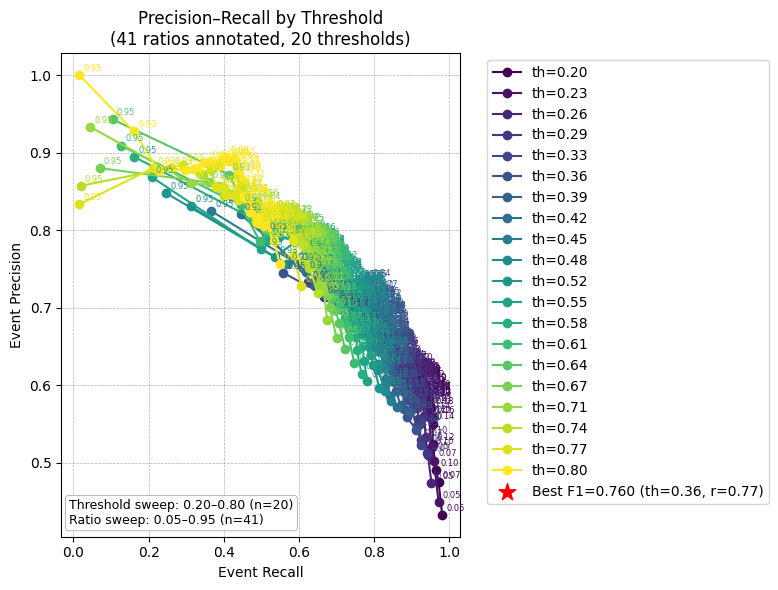

    threshold  ratio  recall_evt  precision_evt  coverage_mean     F1
0         0.2  0.050       0.981          0.433          0.893  0.600
1         0.2  0.072       0.972          0.475          0.866  0.638
2         0.2  0.095       0.965          0.490          0.855  0.650
3         0.2  0.118       0.956          0.524          0.839  0.677
4         0.2  0.140       0.956          0.550          0.827  0.698
5         0.2  0.162       0.956          0.559          0.822  0.706
6         0.2  0.185       0.953          0.570          0.819  0.713
7         0.2  0.208       0.950          0.573          0.812  0.715
8         0.2  0.230       0.946          0.582          0.806  0.721
9         0.2  0.252       0.943          0.583          0.801  0.721
10        0.2  0.275       0.943          0.581          0.798  0.719
11        0.2  0.298       0.943          0.584          0.794  0.721
12        0.2  0.320       0.943          0.589          0.787  0.725
13        0.2  0.342

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib.cm as cm

# ───────────────────────────────────────────────────────────────
# 1) Hyperparameters to sweep (values shown below are examples)
# ───────────────────────────────────────────────────────────────
threshold_list = np.linspace(0.20, 0.80, 20)   # 10 values from 0.40 to 0.90
ratio_list     = np.linspace(0.05, 0.95, 41)   # 41 values from 0.05 to 0.95

# ───────────────────────────────────────────────────────────────
# 2) Double loop: threshold × ratio
# ───────────────────────────────────────────────────────────────
results = []

for th in threshold_list:
    # 2-a) Binary sequences for THIS probability threshold
    x_list, pred_list, label_list, prob_list = collect_sequences(
        model, val_ds, thresh=th
    )

    for r in ratio_list:
        # 2-b) Grouping by identifier (keep the same threshold as above)
        ts_dict = regroup_timeseries_multi(
            x_list, pred_list, label_list,
            sub_test=sub_test,
            ratio=r,
            prob_list=prob_list,
            threshold=th     # ← consistent with collect_sequences(thresh=th)
        )

        # 2-c) Event-level metrics
        m = compute_event_metrics(ts_dict, prob_list=False, imprecision=3)

        prec, rec, cov = m['precision_evt'], m['recall_evt'], m['coverage_mean']

        # Skip cases with no events (NaN)
        if np.isnan(prec) or np.isnan(rec):
            continue

        f1 = 2 * prec * rec / (prec + rec + 1e-12)

        results.append({
            'threshold'     : th,
            'ratio'         : r,
            'precision_evt' : prec,
            'recall_evt'    : rec,
            'coverage_mean' : cov,
            'F1'            : f1,
        })

# ───────────────────────────────────────────────────────────────
# 3) Best result
# ───────────────────────────────────────────────────────────────
res_df  = pd.DataFrame(results).round(4)

# 1) Only keep rows with valid precision/recall
valid_df = res_df.dropna(subset=['precision_evt', 'recall_evt']).copy()

# 2) Colors per threshold (optional)
unique_th = np.sort(valid_df['threshold'].unique())
colors    = cm.viridis(np.linspace(0, 1, len(unique_th)))

# 3) Multi-threshold PR figure (all texts in English)
plt.figure(figsize=(8, 6))
ax = plt.gca()

for th, color in zip(unique_th, colors):
    sub = valid_df[valid_df['threshold'] == th].sort_values('recall_evt')
    if sub.empty:
        continue

    recalls    = sub['recall_evt'].to_numpy()
    precisions = sub['precision_evt'].to_numpy()
    ratios     = sub['ratio'].to_numpy()

    # PR curve for THIS threshold
    plt.plot(recalls, precisions, marker='o', linestyle='-',
             label=f'th={th:.2f}', color=color)

    # Ratio annotation on each point
    for rcl, prc, rat in zip(recalls, precisions, ratios):
        plt.annotate(f'{rat:.2f}',
                     xy=(rcl, prc), xytext=(3, 3),
                     textcoords='offset points', fontsize=6, color=color)

    # (optional) PR AUC for info
    order  = np.argsort(recalls)
    auc_pr = auc(recalls[order], precisions[order])
    # You could append AUC to the legend label if desired.

# 4) Star marker on the best (threshold, ratio) by F1
if not valid_df.empty:
    best = valid_df.loc[valid_df['F1'].idxmax()]
    plt.scatter(best['recall_evt'], best['precision_evt'],
                s=160, marker='*', color='red',
                label=(f"Best F1={best['F1']:.3f} "
                       f"(th={best['threshold']:.2f}, r={best['ratio']:.2f})"))

# 5) Styling (English labels & title)
plt.xlabel('Event Recall')
plt.ylabel('Event Precision')
plt.title('Precision–Recall by Threshold\n'
          f'({len(ratio_list)} ratios annotated, {len(threshold_list)} thresholds)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# >>> Add a clear overlay with the SEARCH RANGES (in English)
ranges_text = (f"Threshold sweep: {threshold_list.min():.2f}–{threshold_list.max():.2f} "
               f"(n={len(threshold_list)})\n"
               f"Ratio sweep: {ratio_list.min():.2f}–{ratio_list.max():.2f} "
               f"(n={len(ratio_list)})")
ax.text(0.02, 0.02, ranges_text,
        transform=ax.transAxes, fontsize=9, va='bottom', ha='left',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5, alpha=0.8))

plt.tight_layout()
plt.show()

# 6) (optional) Summary table
summary = (valid_df[['threshold', 'ratio',
                     'recall_evt', 'precision_evt',
                     'coverage_mean', 'F1']]
           .round(3)
           .sort_values(['threshold', 'ratio'])
           .reset_index(drop=True))

print(summary.head(15))


# Hyperparameter tuning

In [61]:
pos_w = 5
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(pos_w, device=device, dtype=torch.float32)
)

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import copy

# Configuration
random.seed(42)
torch.manual_seed(42)

EPOCHS = 5
N_TRIALS = 15

param_grid = {
    "lr": [1e-4,1e-3, 3e-3],
    "dropout": [0.2, 0.4, 0.6],
    "c_out": [16, 32, 64],
    "hidden_size": [16, 32, 64],
    "batch_size": [32, 64, 128]
}

# Générer N configurations aléatoires
param_keys = list(param_grid.keys())
param_values = list(param_grid.values())
random_configs = [
    tuple(random.choice(param_values[i]) for i in range(len(param_keys)))
    for _ in range(N_TRIALS)
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for i, (lr, dr, c_out, h, batch_size) in enumerate(random_configs):
    print(f"\n🔁 Config {i+1}/{N_TRIALS} ➜ lr={lr}, dropout={dr}, c_out={c_out}, h={h}, batch={batch_size}")

    model = CNN_Dilated_BiLSTM_Attn(inputs_channel=1, c_out=c_out, h=h, dr=dr).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # criterion = nn.BCEWithLogitsLoss()

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=len(train_dl), epochs=EPOCHS
    )

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    best_epoch = 0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * xb.size(0)
        epoch_train_loss = running_loss / len(train_dl.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)

        epoch_val_loss = val_loss / len(val_dl.dataset)
        print(f"Epoch {epoch} ➜ Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

    results.append({
        "config": {"lr": lr, "dropout": dr, "c_out": c_out, "h": h, "batch_size": batch_size},
        "val_loss": best_val_loss,
        "epoch": best_epoch,
        "model_state": best_model_wts
    })

# Sélection du meilleur modèle basé uniquement sur val_loss
best = min(results, key=lambda x: x["val_loss"])
print(f"\n🏆 Best config:\n{best['config']}")
print(f"📉 Best Val Loss: {best['val_loss']:.4f} at Epoch {best['epoch']}")

# Sauvegarde du meilleur modèle
# torch.save(best["model_state"], "best_meal_detector.pth")
# print("✅ Meilleur modèle sauvegardé sous 'best_meal_detector.pth'")


In [ ]:
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy

# Configuration
random.seed(42)
torch.manual_seed(42)

EPOCHS     = 10
N_TRIALS   = 70     # ≤ nombre total de combinaisons (243 ici)

param_grid = {
    "lr"         : [1e-4, 5e-4, 1e-3],
    "dropout"    : [0.2, 0.4, 0.6],
    "c_out"      : [8, 16, 32],
    "hidden_size": [8, 16, 32, 64],
    "batch_size" : [16, 32, 64]
}

# --- Tirage sans remise ------------------------------------------------------
param_keys   = list(param_grid.keys())
param_values = list(param_grid.values())

# 1) Générer toutes les combinaisons possibles
all_configs = list(itertools.product(*param_values))          # 243 tuples

# 2) Prélever N_TRIALS combinaisons distinctes, ordre aléatoire
random_configs = random.sample(all_configs, N_TRIALS)         # aucune répétition
# -----------------------------------------------------------------------------

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for i, (lr, dr, c_out, h, batch_size) in enumerate(random_configs, 1):
    print(f"\n🔁 Config {i}/{N_TRIALS} ➜ lr={lr}, dropout={dr}, c_out={c_out}, h={h}, batch={batch_size}")

    model = CNN_Dilated_BiLSTM_Attn(inputs_channel=1, c_out=c_out, h=h, dr=dr).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # criterion = nn.BCEWithLogitsLoss()

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=len(train_dl), epochs=EPOCHS
    )

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss  = float("inf")
    best_epoch     = 0

    for epoch in range(1, EPOCHS + 1):
        # --- Entraînement -----------------------------------------------------
        model.train()
        running_loss = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * xb.size(0)
        epoch_train_loss = running_loss / len(train_dl.dataset)

        # --- Validation -------------------------------------------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss   = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
        epoch_val_loss = val_loss / len(val_dl.dataset)
        print(f"Epoch {epoch} ➜ Train: {epoch_train_loss:.4f} | Val: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss  = epoch_val_loss
            best_epoch     = epoch
            best_model_wts = copy.deepcopy(model.state_dict())

    results.append({
        "config"      : {"lr": lr, "dropout": dr, "c_out": c_out,
                         "h": h, "batch_size": batch_size},
        "val_loss"    : best_val_loss,
        "epoch"       : best_epoch,
        "model_state" : best_model_wts
    })

# Meilleur modèle
best = min(results, key=lambda x: x["val_loss"])
print(f"\n🏆 Best config:\n{best['config']}")
print(f"📉 Best Val Loss: {best['val_loss']:.4f} at Epoch {best['epoch']}")
# torch.save(best["model_state"], "best_meal_detector.pth")
